In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
from collections import defaultdict
import glob
import librosa
from tqdm import tqdm
import numpy as np
import moviepy.editor as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from sklearn.preprocessing import minmax_scale

In [2]:
AUDIO_DIR = f"{os.path.abspath('./../../')}/eNTERFACE05_Dataset/*/*/*/*.avi"
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"

In [12]:
config = Configuration.load_json(CONFIG_FILE)

In [4]:
def get_emotion_files(audio_dir) -> defaultdict:
    emotion_data = defaultdict(lambda: defaultdict(list))

    for file_path in glob.glob(audio_dir):
        emotion = file_path.split('/')[-3]

        file_type = file_path.split('.')[-1]

        if file_type == 'avi':
            audio_file_path = file_path[:-3] + 'wav'

            # convert file type to wav
            if not os.path.isfile(audio_file_path):
                audio_clip = mp.VideoFileClip(file_path)
                audio_clip.audio.write_audiofile(audio_file_path)

            file_path = audio_file_path

        emotion_data[emotion]['files'].append(file_path)

    return emotion_data

In [5]:
# get the files corresponding to each emotion
emotion_data = get_emotion_files(AUDIO_DIR)

In [6]:
def extract_features(signal, sr):
    return [
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(signal)[0, 0],
        librosa.feature.melspectrogram(signal, sr=sr, n_mels=config.n_mels),
        librosa.feature.mfcc(y=signal, sr=sr)
    ]

In [7]:
def process_data(emotion_data):
    for emotion, data in emotion_data.items():
        for audio_file in tqdm(data['files']):
            signal, sr = librosa.load(audio_file, res_type='kaiser_fast')

            data['features'].append(extract_features(signal, sr))

        # just for one file
        print("Emotion: ", emotion)
        print("Total number of samples: ", signal.shape[0])
        print("Sample rate: ", sr)
        print("Audio Duration (s): ", librosa.get_duration(signal))

In [8]:
# extract features from audio files
process_data(emotion_data)

100%|██████████| 215/215 [00:13<00:00, 15.73it/s]


Emotion:  fear
Total number of samples:  35280
Sample rate:  22050
Audio Duration (s):  1.6


100%|██████████| 215/215 [00:16<00:00, 13.19it/s]


Emotion:  surprise
Total number of samples:  67914
Sample rate:  22050
Audio Duration (s):  3.08


100%|██████████| 215/215 [00:18<00:00, 11.70it/s]


Emotion:  sadness
Total number of samples:  76734
Sample rate:  22050
Audio Duration (s):  3.48


100%|██████████| 212/212 [00:15<00:00, 13.78it/s]


Emotion:  happiness
Total number of samples:  59976
Sample rate:  22050
Audio Duration (s):  2.72


100%|██████████| 215/215 [00:18<00:00, 11.47it/s]


Emotion:  anger
Total number of samples:  80262
Sample rate:  22050
Audio Duration (s):  3.64


100%|██████████| 215/215 [00:16<00:00, 12.70it/s]

Emotion:  disgust
Total number of samples:  37926
Sample rate:  22050
Audio Duration (s):  1.72


In [14]:
def display_melspecgram(mel_fig, axs, i, emotion, melspecgram):
    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = ax.pcolormesh(melspecgram, cmap="magma")
    ax.set_title(emotion)
    mel_fig.colorbar(im, ax=ax)

In [15]:
def analyse_features(emotion_data):
    mel_fig, mel_axs = plt.subplots(2, 3, figsize=(16,8))
    mel_fig.suptitle("Log-Mel Magnitude Spectrogram")
    for ax in mel_axs.flat:
        ax.set(xlabel="Time (sample)", ylabel="Log-Mel Bins (mel)")
    for ax in mel_axs.flat:
        ax.label_outer()

    zero_cr_means, spect_cent_means = [], []

    for fig_pos, emotion in enumerate(emotion_data):
        data = emotion_data[emotion]
        features = np.array(data['features'])

        # using only mel_spectogram of the first audio file for testing
        spec = features[0, 2]
        display_melspecgram(mel_fig, mel_axs, fig_pos, emotion, spec)

        # scaling features between 0 and 1
        cross_rate_values = minmax_scale(features[:,0], config.scale_range)
        spec_cent_values = minmax_scale(features[:,1], config.scale_range)
        # avering features
        zero_cr_means.append(np.mean(cross_rate_values))
        spect_cent_means.append(np.mean(spec_cent_values))

    df = pd.DataFrame(zip(list(emotion_data.keys())*6, ["Mean Zero Crossing Rate"]*6+["Mean Spectral Centroid"]*6,\
        zero_cr_means+spect_cent_means), columns=["Emotion", "Mean Values", 'Value'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Emotion", hue="Mean Values", y="Value", data=df)
    plt.show()

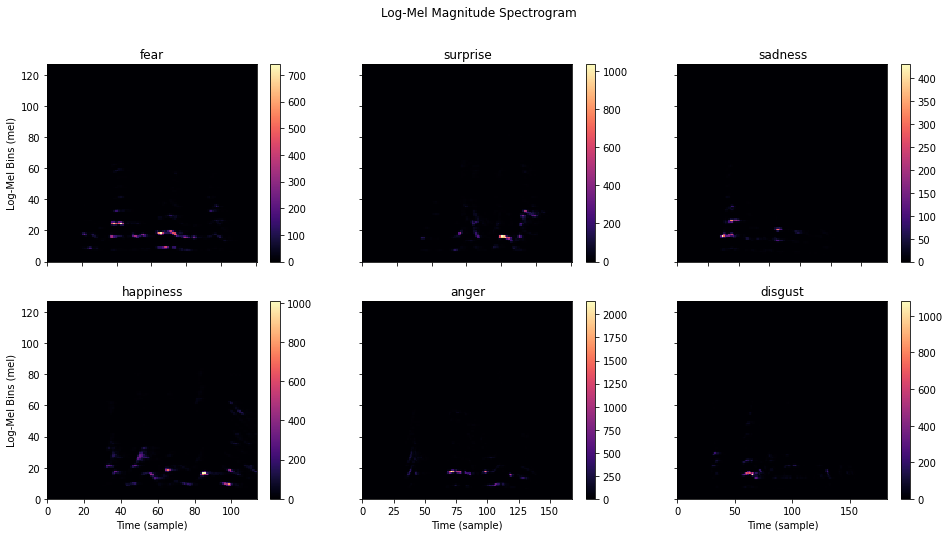

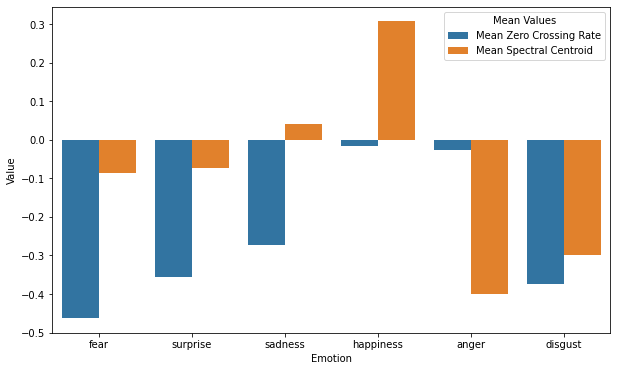

In [16]:
# analyse the extracted features
analyse_features(emotion_data)